<h1><center>K-Nearest Neighbors</center></h1>

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


### Libraries

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import roc_auc_score,roc_curve,auc, recall_score
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier

### Load Data

In [0]:
data_card = pd.read_csv('/content/drive/My Drive/Projet_Apprentissage_Supervisé_1819/creditcard.csv')

In [5]:
data_card.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Check if there are null values

In [6]:
data_card.isnull().values.any()

False

### Plot class frequencies

In [0]:
compter = data_card["Class"].value_counts()

In [0]:
name_labels = ['Not Fraud','Fraud']
def plot_bar_x():
    index = np.arange(len(name_labels))
    colours = ['#1F77B4','#FF7F0E']
    plt.figure(figsize=(15,8))
    label = [compter.values[0],compter.values[1]]
    for i in range(len(index)):
        plt.bar(index[i], compter.values[i],align='center', alpha=0.5,color = colours[i])
        plt.text(x = index[i]-0.1 , y = compter.values[i]+5000, s = label[i], size = 12)
    plt.legend(name_labels)
    plt.xlabel('Class', fontsize=2, size = 20)
    plt.ylabel('Number of transactions', fontsize=5,size = 20)
    plt.xticks(index, name_labels, fontsize=5,size = 16, color = 'gray')
    plt.title('Credit Card Fraud Class - data unbalance', size = 22)
    plt.grid(linewidth = 0.2)
    
    plt.show()

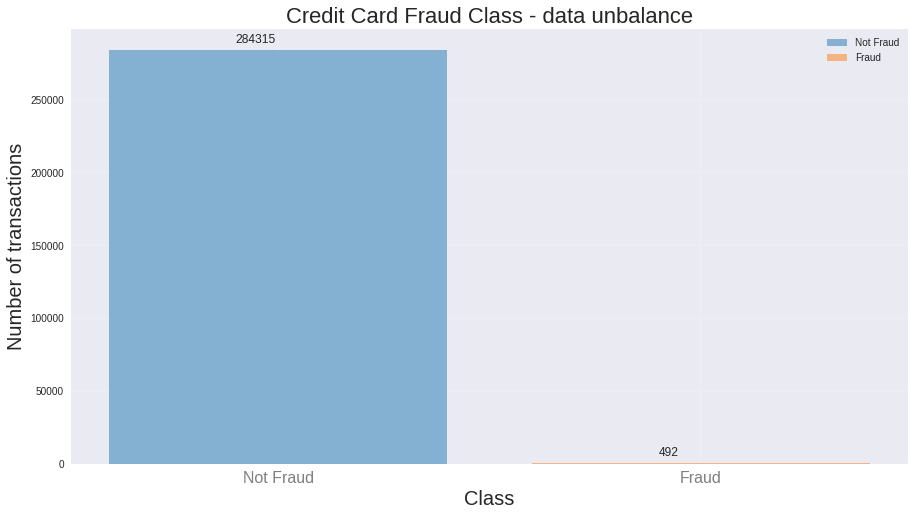

In [9]:
plot_bar_x()

### Plot correlation matrix

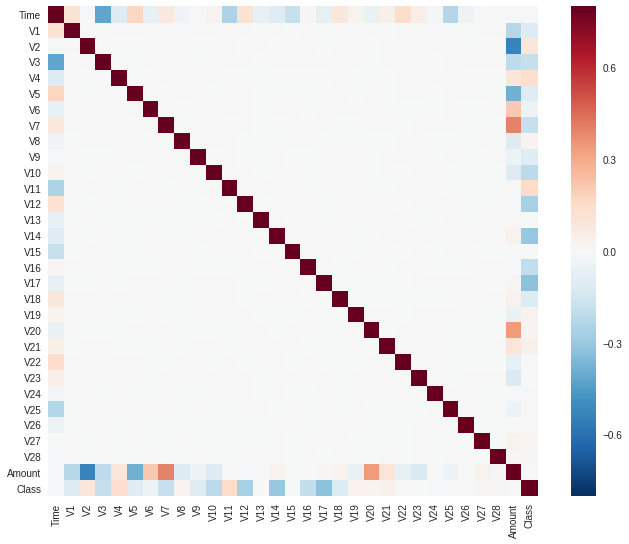

In [10]:
correlation_matrix = data_card.corr()
fig = plt.figure(figsize=(12,9))
sns.heatmap(correlation_matrix,vmax=0.8,square = True)
plt.show()

### Describe data of first and second classes

In [0]:
no_trans = data_card[data_card['Class'] == 0]
fraud_trans = data_card[data_card['Class'] == 1]

#### Class = 0

In [12]:
no_trans['Amount'].describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

#### Class = 1

In [13]:
fraud_trans['Amount'].describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

### Plot Time and Amount Variables

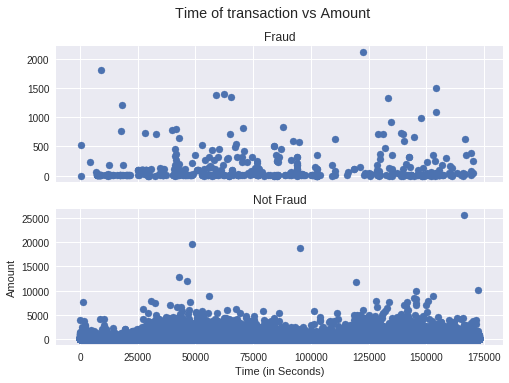

In [14]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount')

ax1.scatter(fraud_trans['Time'], fraud_trans['Amount'])
ax1.set_title('Fraud')

ax2.scatter(no_trans['Time'], no_trans['Amount'])
ax2.set_title('Not Fraud')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

### Drop Time feature
### Stander scale Amount feature

In [0]:
data_card = data_card.drop(['Time'], axis=1)

data_card['Amount'] = StandardScaler().fit_transform(data_card['Amount'].values.reshape(-1, 1))

### Split data to train and test

In [0]:
train_df, test_df = train_test_split(data_card, test_size=0.33, random_state=42, shuffle=True)

In [0]:
index = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

## K-nearest neighbors algorithm on original data with K=7

In [18]:
neigh = KNeighborsClassifier(n_neighbors=7)
neigh.fit(train_df[index],train_df['Class'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=7, p=2,
           weights='uniform')

### Predections 

In [0]:
preds = neigh.predict(test_df[index])

### Compute roc auc score and recall score 

In [20]:
print('roc-auc score is: ',roc_auc_score(test_df['Class'].values, preds))
print('recall score is: ',recall_score(test_df['Class'].values, preds))

roc-auc score is:  0.8925215396919237
recall score is:  0.785234899328859


### Plot confusion matrix 

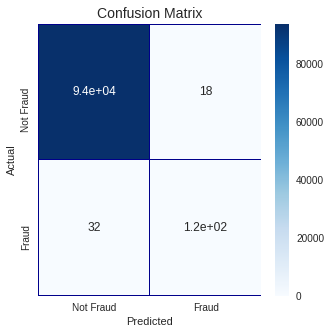

In [21]:
cm = pd.crosstab(test_df['Class'].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

### Plot roc-auc Curve 

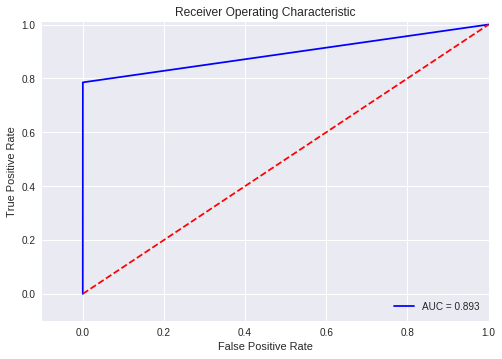

In [22]:
fpr, tpr, thresholds = roc_curve(test_df['Class'].values, preds)

roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Oversample train Data

In [0]:
os = SMOTE(random_state=42)

In [0]:
os_data_train,os_label_train = os.fit_sample(train_df[index],train_df['Class'])

In [25]:
os_data_X = pd.DataFrame(data=os_data_train,columns=index)
os_data_y= pd.DataFrame(data=os_label_train,columns=['Class'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['Class']==0]))
print("Number of subscription",len(os_data_y[os_data_y['Class']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['Class']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['Class']==1])/len(os_data_X))

length of oversampled data is  380954
Number of no subscription in oversampled data 190477
Number of subscription 190477
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


## K-nearest neighbors on oversampled data with k = 7

In [26]:
neigh1 = KNeighborsClassifier(n_neighbors=7)
neigh1.fit(os_data_X,os_data_y)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=7, p=2,
           weights='uniform')

### Predictions

In [0]:
preds1 = neigh1.predict(test_df[index])

### Compute roc-auc and recall scores

In [28]:
print('roc-auc score is: ',roc_auc_score(test_df['Class'].values, preds1))
print('recall score is: ',recall_score(test_df['Class'].values, preds1))

roc-auc score is:  0.9451844468211745
recall score is:  0.8926174496644296


### Plot confusion matrix

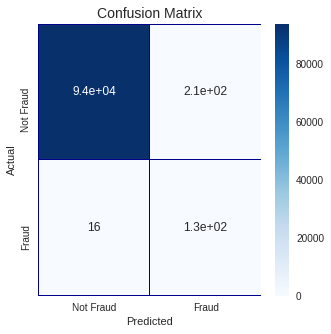

In [29]:
cm = pd.crosstab(test_df['Class'].values, preds1, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

### Plot roc-auc curve

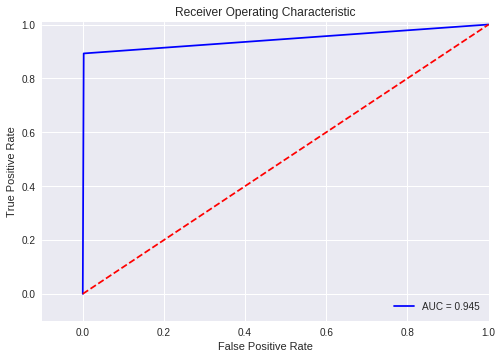

In [30]:
fpr, tpr, thresholds = roc_curve(test_df['Class'].values, preds1)

roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()